# Lets predict Lung Cancer using Ensemble Stacking classifier
## Lets stack all classifications and see how stacking performs


Import Section 


In [54]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from  sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,log_loss,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')
import operator
import copy
import json
import pickle
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

Lets work on the cancer dataset

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!mkdir lungcancer
!kaggle datasets download -d mysarahmadbhat/lung-cancer
!unzip lung-cancer.zip -d lungcancer

Saving kaggle.json to kaggle.json
  0% 0.00/2.00k [00:00<?, ?B/s]
100% 2.00k/2.00k [00:00<00:00, 1.91MB/s]
Archive:  lung-cancer.zip
  inflating: lungcancer/survey lung cancer.csv  


Lets Load the dataset

In [3]:
cancerdata = pd.read_csv('/content/lungcancer/survey lung cancer.csv')
cancerdata.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [4]:
cancerdata.GENDER = cancerdata.GENDER.map({'M':0,'F':1})
cancerdata.LUNG_CANCER = cancerdata.LUNG_CANCER.map({'NO':0,'YES':1})
for column in cancerdata.columns[2:-1]:
  cancerdata[column] = cancerdata[column].apply(lambda X: X-1)
cancerdata

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,0,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,0,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,1,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,0,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,1,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,1,56,0,0,0,1,1,1,0,0,1,1,1,1,0,1
305,0,70,1,0,0,0,0,1,1,1,1,1,1,0,1,1
306,0,58,1,0,0,0,0,0,1,1,1,1,0,0,1,1
307,0,67,1,0,1,0,0,1,1,0,1,1,1,0,1,1


In [5]:
X = cancerdata.drop(['LUNG_CANCER'], axis = 1)
y = cancerdata['LUNG_CANCER']

In [6]:
y.value_counts()

1    270
0     39
Name: LUNG_CANCER, dtype: int64

In [7]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42, n_jobs = -1)
X, y = smt.fit_resample(X, y)

In [8]:
print(X.shape)
print(y.shape)

(532, 15)
(532,)


In [9]:
print('nulls in X  : \n\n' ,X.isnull().sum(),'\n')
print('nulls in y  : \n\n' ,y.isnull().sum())

nulls in X  : 

 GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
dtype: int64 

nulls in y  : 

 0


# Now lets import different classifiers from Sklearn and grid search for hyper parameter tuning

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(425, 15)
(107, 15)
(425,)
(107,)


In [12]:
X_train.AGE.shape

(425,)

In [13]:
scalar = StandardScaler()
X_train.AGE = scalar.fit_transform(np.array(X_train.AGE).reshape(-1,1))
X_test.AGE = scalar.transform(np.array(X_test.AGE).reshape(-1,1))


# For stacking the base classifiers we need the best fitted base classifiers
## unlike bagging , in bagging we need low bias and high variance models as base models
## and in boosting we need high bias and low variance models as base models.

In [55]:
result_dataset = pd.DataFrame(data =np.zeros((4,9)) , index = ['accuracy_score','f1_score','roc_auc_score','log_loss'],columns = ['KNN','NaiveBayes','Logistic_Regression','SVC','DecisionTrees','RF','GBDT','Stacked_classifer','voting_classifier'])
result_dataset

,KNN,NaiveBayes,Logistic_Regression,SVC,DecisionTrees,RF,GBDT,Stacked_classifer,voting_classifier
accuracy_score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
def metrics(classfier,X_test,y_test,name):
  y_pred = classfier.predict(X_test)
  y_prob = classfier.predict_proba(X_test)[:,[1]]
  accuracy = accuracy_score(y_test,y_pred)
  rocauc = roc_auc_score(y_test,y_prob)
  logloss = log_loss(y_test,y_prob)
  f1score = f1_score(y_test,y_pred)
  result_dataset[name]['accuracy_score'] = accuracy
  result_dataset[name]['f1_score'] = f1score
  result_dataset[name]['roc_auc_score'] = rocauc
  result_dataset[name]['log_loss'] = logloss
  print("accuracy score :",accuracy)
  print("f1 score :",f1score)
  print("auc score :",rocauc)
  print("log loss :",logloss)
  print('classification report : \n', classification_report(y_test,y_pred))
  print('*********** confusion matrx ***********')
  sns.heatmap(confusion_matrix(y_test,y_pred),annot = True, cmap = 'Blues')
  plt.show()
  return y_pred

## Now lets start with KNN Classifer

In [ ]:
knn_classif = KNeighborsClassifier()
param_grids = {'base_estimator__n_neighbors' : [1, 2, 3, 4, 5],'max_features' : [0.3,0.4,0.5,0.6,0.7],'n_estimators':[25,28,30,32,35],'max_samples' : [0.4,0.5,0.6,0.7,0.8]}
knn_classif = GridSearchCV(estimator = BaggingClassifier(knn_classif),param_grid = param_grids,cv = 5, scoring = 'accuracy', n_jobs = -1)
knn_classif.fit(X_train,y_train)
knn_classif.best_estimator_

BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=4),
                  max_features=0.5, max_samples=0.8, n_estimators=28)

BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=4),
                  max_features=0.5, max_samples=0.8, n_estimators=28)

In [17]:
knn_classif = KNeighborsClassifier(n_neighbors = 4)
knn_classif =BaggingClassifier(knn_classif,max_features=0.5,max_samples=0.8, n_estimators=28,n_jobs =-1)
knn_classif.fit(X_train,y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=4),
                  max_features=0.5, max_samples=0.8, n_estimators=28,
                  n_jobs=-1)

accuracy score : 0.9719626168224299
f1 score : 0.970873786407767
auc score : 0.9940600978336828
log loss : 0.13666668611902105
classification report : 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        54
           1       1.00      0.94      0.97        53

    accuracy                           0.97       107
   macro avg       0.97      0.97      0.97       107
weighted avg       0.97      0.97      0.97       107

*********** confusion matrx ***********


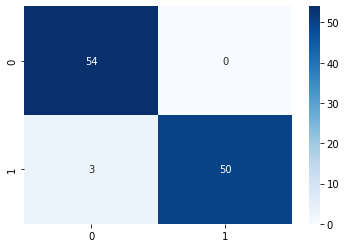

,KNN,NaiveBayes,Logistic_Regression,SVC,DecisionTrees,RF,GBDT,Stacked_classifer,voting_classifier
accuracy_score,0.971963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.970874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.994060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,0.136667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
knn_classif_pred = metrics(knn_classif,X_test,y_test,'KNN')
result_dataset


# Now lets use gaussian Naive Bayes

In [ ]:
naive_classif = GaussianNB()
param_grids = {'base_estimator__var_smoothing' : np.logspace(0,-9, num=10),'max_features' : [0.3,0.4,0.5,0.6,0.7],'n_estimators':[25,28,30,32,35],'max_samples' : [0.4,0.5,0.6,0.7,0.8]}
naive_classif = GridSearchCV(estimator = BaggingClassifier(naive_classif),param_grid = param_grids,cv = 5, scoring = 'accuracy',verbose = 2)
naive_classif.fit(X_train,y_train)
naive_classif.best_estimator_

BaggingClassifier(base_estimator=GaussianNB(var_smoothing=1e-07),
                  max_features=0.3, max_samples=0.8, n_estimators=28)

In [21]:
naive_classif = GaussianNB(var_smoothing=1e-07)
naive_classif =BaggingClassifier(naive_classif,max_features=0.3,max_samples=0.8, n_estimators=28,n_jobs =-1)
naive_classif.fit(X_train,y_train)

BaggingClassifier(base_estimator=GaussianNB(var_smoothing=1e-07),
                  max_features=0.3, max_samples=0.8, n_estimators=28,
                  n_jobs=-1)

accuracy score : 0.9252336448598131
f1 score : 0.9245283018867925
auc score : 0.9874213836477989
log loss : 0.23028988329791084
classification report : 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        54
           1       0.92      0.92      0.92        53

    accuracy                           0.93       107
   macro avg       0.93      0.93      0.93       107
weighted avg       0.93      0.93      0.93       107

*********** confusion matrx ***********


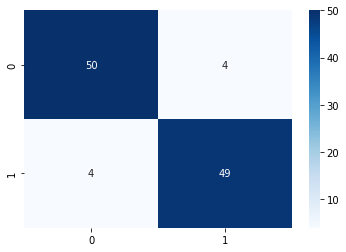

,KNN,NaiveBayes,Logistic_Regression,SVC,DecisionTrees,RF,GBDT,Stacked_classifer,voting_classifier
accuracy_score,0.971963,0.925234,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.970874,0.924528,0.0,0.0,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.994060,0.987421,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,0.136667,0.230290,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
naive_classif_pred = metrics(naive_classif,X_test,y_test,'NaiveBayes')
result_dataset

# Now lets use logistic regression 

In [ ]:
logistic_clf = LogisticRegression()
param_grids = {'base_estimator__C': [0.0001, 0.01, 1.0, 10.0,100.0, 1000.0],'max_features' : [0.3,0.4,0.5,0.6,0.7],'n_estimators':[25,28,30,32,35],'max_samples' : [0.4,0.5,0.6,0.7,0.8]}
logistic_classif = GridSearchCV(estimator = BaggingClassifier(logistic_clf),param_grid = param_grids,cv = 5, scoring = 'accuracy',verbose = 2)
logistic_classif.fit(X_train,y_train)
logistic_classif.best_estimator_

BaggingClassifier(base_estimator=LogisticRegression(), max_features=0.6,
                  max_samples=0.6, n_estimators=28)

In [23]:
logistic_classif = LogisticRegression()
logistic_classif =BaggingClassifier(logistic_classif,max_features=0.6,max_samples=0.6, n_estimators=28,n_jobs =-1)
logistic_classif.fit(X_train,y_train)

BaggingClassifier(base_estimator=LogisticRegression(), max_features=0.6,
                  max_samples=0.6, n_estimators=28, n_jobs=-1)

accuracy score : 0.9906542056074766
f1 score : 0.9904761904761905
auc score : 0.9923130677847659
log loss : 0.15718593455705712
classification report : 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       1.00      0.98      0.99        53

    accuracy                           0.99       107
   macro avg       0.99      0.99      0.99       107
weighted avg       0.99      0.99      0.99       107

*********** confusion matrx ***********


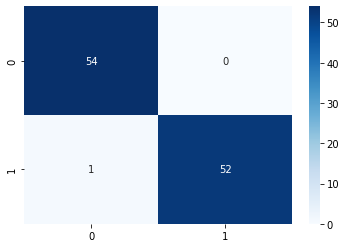

,KNN,NaiveBayes,Logistic_Regression,SVC,DecisionTrees,RF,GBDT,Stacked_classifer,voting_classifier
accuracy_score,0.971963,0.925234,0.990654,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.970874,0.924528,0.990476,0.0,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.994060,0.987421,0.992313,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,0.136667,0.230290,0.157186,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
logistic_classif_pred = metrics(logistic_classif,X_test,y_test,'Logistic_Regression')
result_dataset

# Now lets use Support Vector Classifier

In [ ]:
svc_clf = SVC()
param_grids = {'base_estimator__C': [0.0001, 0.01, 1.0, 10.0],'base_estimator__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],'max_features' : [0.4,0.5,0.6],'n_estimators':[25,28,30,32,35],'max_samples' : [0.5,0.6,0.7]}
svc_classif = GridSearchCV(estimator = BaggingClassifier(svc_clf),param_grid = param_grids,cv = 5, scoring = 'accuracy',verbose = 2)
svc_classif.fit(X_train,y_train)
svc_classif.best_estimator_

BaggingClassifier(base_estimator=SVC(), max_features=0.5, max_samples=0.5,
                  n_estimators=32)

In [25]:
svc_classif = SVC(C=1.0,random_state = 42)
svc_classif =BaggingClassifier(svc_classif,max_features=0.5,max_samples=0.5, n_estimators=32,n_jobs =-1,random_state = 42)
svc_classif.fit(X_train,y_train)

BaggingClassifier(base_estimator=SVC(random_state=42), max_features=0.5,
                  max_samples=0.5, n_estimators=32, n_jobs=-1, random_state=42)

accuracy score : 0.9439252336448598
f1 score : 0.9433962264150944
auc score : 0.9820055904961564
log loss : 0.43645044975823755
classification report : 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94        54
           1       0.94      0.94      0.94        53

    accuracy                           0.94       107
   macro avg       0.94      0.94      0.94       107
weighted avg       0.94      0.94      0.94       107

*********** confusion matrx ***********


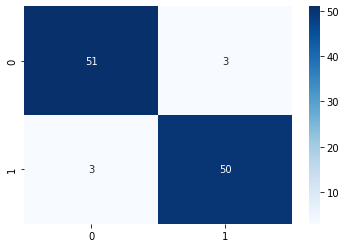

,KNN,NaiveBayes,Logistic_Regression,SVC,DecisionTrees,RF,GBDT,Stacked_classifer,voting_classifier
accuracy_score,0.971963,0.925234,0.990654,0.943925,0.0,0.0,0.0,0.0,0.0
f1_score,0.970874,0.924528,0.990476,0.943396,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.994060,0.987421,0.992313,0.982006,0.0,0.0,0.0,0.0,0.0
log_loss,0.136667,0.230290,0.157186,0.436450,0.0,0.0,0.0,0.0,0.0


In [59]:
svc_classif_pred = metrics(svc_classif,X_test,y_test,'SVC')
result_dataset

# Now lets use Decision Tree

In [ ]:
Dt_clf = DecisionTreeClassifier(max_features = 'auto',random_state = 42)
param_grids = {'base_estimator__criterion': ['gini','entropy'],'base_estimator__max_depth' : [15,20,25,30,35,40],'max_features' : [0.4,0.5,0.6],'n_estimators':[25,28,30,32,35],'max_samples' : [0.5,0.6,0.7]}
Dt_classif = GridSearchCV(estimator = BaggingClassifier(Dt_clf),param_grid = param_grids,cv = 5, scoring = 'accuracy',verbose = 2)
Dt_classif.fit(X_train,y_train)
Dt_classif.best_estimator_

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=30,
                                                        max_features='auto',
                                                        random_state=42),
                  max_features=0.4, max_samples=0.7, n_estimators=32)

In [27]:
Dt_classif = DecisionTreeClassifier(max_depth = 30,max_features = 'auto',random_state = 42) 
Dt_classif =BaggingClassifier(Dt_classif,max_features=0.4,max_samples=0.7, n_estimators=32,n_jobs =-1,random_state = 42)
Dt_classif.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=30,
                                                        max_features='auto',
                                                        random_state=42),
                  max_features=0.4, max_samples=0.7, n_estimators=32, n_jobs=-1,
                  random_state=42)

accuracy score : 0.9532710280373832
f1 score : 0.9523809523809524
auc score : 0.9926624737945492
log loss : 0.15919200278876602
classification report : 
               precision    recall  f1-score   support

           0       0.95      0.96      0.95        54
           1       0.96      0.94      0.95        53

    accuracy                           0.95       107
   macro avg       0.95      0.95      0.95       107
weighted avg       0.95      0.95      0.95       107

*********** confusion matrx ***********


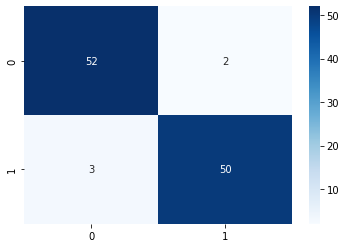

,KNN,NaiveBayes,Logistic_Regression,SVC,DecisionTrees,RF,GBDT,Stacked_classifer,voting_classifier
accuracy_score,0.971963,0.925234,0.990654,0.943925,0.953271,0.0,0.0,0.0,0.0
f1_score,0.970874,0.924528,0.990476,0.943396,0.952381,0.0,0.0,0.0,0.0
roc_auc_score,0.994060,0.987421,0.992313,0.982006,0.992662,0.0,0.0,0.0,0.0
log_loss,0.136667,0.230290,0.157186,0.436450,0.159192,0.0,0.0,0.0,0.0


In [60]:
Dt_classif_pred = metrics(Dt_classif,X_test,y_test,'DecisionTrees')
result_dataset

# Lets apply random forest

In [ ]:
rf_classif = RandomForestClassifier()
param_grids = {'n_estimators' : [60,65,70,75,80,85,90,95],'criterion' : ['gini', 'entropy'],'max_depth' : [15,17,19,20,22,24,25]}
rf_classif = GridSearchCV(estimator = rf_classif,param_grid = param_grids,cv = 5, scoring = 'accuracy', verbose = 2)
rf_classif.fit(X_train,y_train)
rf_classif.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=85)

In [32]:
rf_classif = RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=85)
rf_classif.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=85)

accuracy score : 0.9719626168224299
f1 score : 0.970873786407767
auc score : 0.9940600978336827
log loss : 0.10485005027103078
classification report : 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        54
           1       1.00      0.94      0.97        53

    accuracy                           0.97       107
   macro avg       0.97      0.97      0.97       107
weighted avg       0.97      0.97      0.97       107

*********** confusion matrx ***********


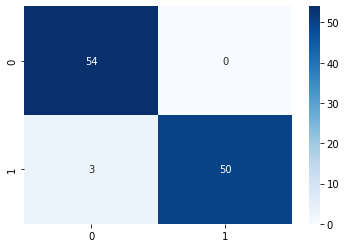

,KNN,NaiveBayes,Logistic_Regression,SVC,DecisionTrees,RF,GBDT,Stacked_classifer,voting_classifier
accuracy_score,0.971963,0.925234,0.990654,0.943925,0.953271,0.971963,0.0,0.0,0.0
f1_score,0.970874,0.924528,0.990476,0.943396,0.952381,0.970874,0.0,0.0,0.0
roc_auc_score,0.994060,0.987421,0.992313,0.982006,0.992662,0.994060,0.0,0.0,0.0
log_loss,0.136667,0.230290,0.157186,0.436450,0.159192,0.104850,0.0,0.0,0.0


In [61]:
rf_classif_pred = metrics(rf_classif,X_test,y_test,'RF')
result_dataset

# lets apply GBDT

In [ ]:
gbdt_clasif = GradientBoostingClassifier(random_state = 42)
param_grids = {'loss' : ['log_loss', 'deviance', 'exponential'],'learning_rate' : [0.1,0.3,0.6,0.9],'n_estimators':[80,90,100,110],'criterion':['friedman_mse','squared_error','mse']}
gbdt_clasif = GridSearchCV(estimator = gbdt_clasif,param_grid = param_grids,cv = 5, scoring = 'accuracy', verbose = 2)
gbdt_clasif.fit(X_train,y_train)
gbdt_clasif.best_estimator_

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.6,random_state=42)

In [34]:
gbdt_clasif = GradientBoostingClassifier(criterion='squared_error', learning_rate=0.6,random_state=42)
gbdt_clasif.fit(X_train,y_train)


GradientBoostingClassifier(criterion='squared_error', learning_rate=0.6,
                           random_state=42)

accuracy score : 0.9719626168224299
f1 score : 0.970873786407767
auc score : 0.9961565338923829
log loss : 0.21961874671436907
classification report : 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        54
           1       1.00      0.94      0.97        53

    accuracy                           0.97       107
   macro avg       0.97      0.97      0.97       107
weighted avg       0.97      0.97      0.97       107

*********** confusion matrx ***********


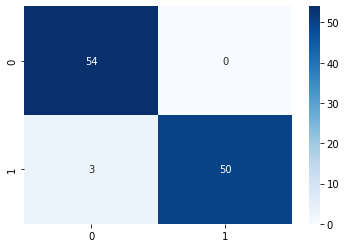

,KNN,NaiveBayes,Logistic_Regression,SVC,DecisionTrees,RF,GBDT,Stacked_classifer,voting_classifier
accuracy_score,0.971963,0.925234,0.990654,0.943925,0.953271,0.971963,0.971963,0.0,0.0
f1_score,0.970874,0.924528,0.990476,0.943396,0.952381,0.970874,0.970874,0.0,0.0
roc_auc_score,0.994060,0.987421,0.992313,0.982006,0.992662,0.994060,0.996157,0.0,0.0
log_loss,0.136667,0.230290,0.157186,0.436450,0.159192,0.104850,0.219619,0.0,0.0


In [62]:
gbdt_clasif_pred = metrics(gbdt_clasif,X_test,y_test,'GBDT')
result_dataset

# lets apply Stacking

In [42]:
estimators = [('knn',knn_classif),('naivebayes',naive_classif),('loisticregression',logistic_classif),('svc',svc_classif),('decisiontree',Dt_classif),('randomforest',rf_classif),('gbdt',gbdt_clasif)]
stacking_classif = StackingClassifier(estimators=estimators, final_estimator=rf_classif)
param_grids = {'stack_method':['auto', 'predict_proba', 'decision_function', 'predict'],'passthrough':[True,False]}
stacking_classif = GridSearchCV(estimator = stacking_classif,param_grid = param_grids,cv = 5, scoring = 'accuracy', verbose = 2)
stacking_classif.fit(X_train,y_train)
stacking_classif.best_estimator_




Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ................passthrough=True, stack_method=auto; total time=   5.8s
[CV] END ................passthrough=True, stack_method=auto; total time=   4.8s
[CV] END ................passthrough=True, stack_method=auto; total time=   4.7s
[CV] END ................passthrough=True, stack_method=auto; total time=   4.8s
[CV] END ................passthrough=True, stack_method=auto; total time=   4.7s
[CV] END .......passthrough=True, stack_method=predict_proba; total time=   4.8s
[CV] END .......passthrough=True, stack_method=predict_proba; total time=   4.7s
[CV] END .......passthrough=True, stack_method=predict_proba; total time=   5.6s
[CV] END .......passthrough=True, stack_method=predict_proba; total time=   4.7s
[CV] END .......passthrough=True, stack_method=predict_proba; total time=   4.8s
[CV] END ...passthrough=True, stack_method=decision_function; total time=   0.6s
[CV] END ...passthrough=True, stack_method=decisi

StackingClassifier(estimators=[('knn',
                                BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=4),
                                                  max_features=0.5,
                                                  max_samples=0.8,
                                                  n_estimators=28, n_jobs=-1)),
                               ('naivebayes',
                                BaggingClassifier(base_estimator=GaussianNB(var_smoothing=1e-07),
                                                  max_features=0.3,
                                                  max_samples=0.8,
                                                  n_estimators=28, n_jobs=-1)),
                               ('loisticregression',
                                BaggingClassifier(bas...
                                                  max_features=0.4,
                                                  max_samples=0.7,
                                        

In [43]:
stacking_classif.best_params_

{'passthrough': False, 'stack_method': 'auto'}

In [52]:
estimators = [('knn',knn_classif),('naivebayes',naive_classif),('loisticregression',logistic_classif),('svc',svc_classif),('decisiontree',Dt_classif),('randomforest',rf_classif),('gbdt',gbdt_clasif)]
stacking_classif = StackingClassifier(estimators=estimators, final_estimator=rf_classif,passthrough = False,stack_method= 'auto' )
stacking_classif.fit(X_train,y_train)

StackingClassifier(estimators=[('knn',
                                BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=4),
                                                  max_features=0.5,
                                                  max_samples=0.8,
                                                  n_estimators=28, n_jobs=-1)),
                               ('naivebayes',
                                BaggingClassifier(base_estimator=GaussianNB(var_smoothing=1e-07),
                                                  max_features=0.3,
                                                  max_samples=0.8,
                                                  n_estimators=28, n_jobs=-1)),
                               ('loisticregression',
                                BaggingClassifier(bas...
                                                  max_features=0.4,
                                                  max_samples=0.7,
                                        

accuracy score : 0.9719626168224299
f1 score : 0.970873786407767
auc score : 0.994409503843466
log loss : 0.09382704550170179
classification report : 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        54
           1       1.00      0.94      0.97        53

    accuracy                           0.97       107
   macro avg       0.97      0.97      0.97       107
weighted avg       0.97      0.97      0.97       107

*********** confusion matrx ***********


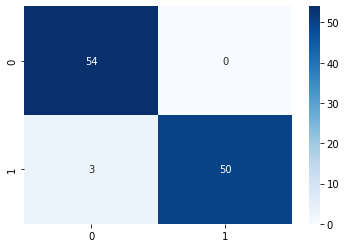

,KNN,NaiveBayes,Logistic_Regression,SVC,DecisionTrees,RF,GBDT,Stacked_classifer,voting_classifier
accuracy_score,0.971963,0.925234,0.990654,0.943925,0.953271,0.971963,0.971963,0.971963,0.0
f1_score,0.970874,0.924528,0.990476,0.943396,0.952381,0.970874,0.970874,0.970874,0.0
roc_auc_score,0.994060,0.987421,0.992313,0.982006,0.992662,0.994060,0.996157,0.994410,0.0
log_loss,0.136667,0.230290,0.157186,0.436450,0.159192,0.104850,0.219619,0.093827,0.0


In [63]:
stacking_classif_pred = metrics(stacking_classif,X_test,y_test,'Stacked_classifer')
result_dataset

# now lets apply voting classifer

In [65]:
estimators = [('knn',knn_classif),('naivebayes',naive_classif),('loisticregression',logistic_classif),('svc',svc_classif),('decisiontree',Dt_classif),('randomforest',rf_classif),('gbdt',gbdt_clasif)]
voting_classif = VotingClassifier(estimators=estimators)
param_grids = {'voting':['hard', 'soft']}
voting_classif = GridSearchCV(estimator = voting_classif,param_grid = param_grids,cv = 5, scoring = 'accuracy', verbose = 2)
voting_classif.fit(X_train,y_train)
voting_classif.best_estimator_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ........................................voting=hard; total time=   1.2s
[CV] END ........................................voting=hard; total time=   1.0s
[CV] END ........................................voting=hard; total time=   0.8s
[CV] END ........................................voting=hard; total time=   0.8s
[CV] END ........................................voting=hard; total time=   0.8s
[CV] END ........................................voting=soft; total time=   0.8s
[CV] END ........................................voting=soft; total time=   0.8s
[CV] END ........................................voting=soft; total time=   0.8s
[CV] END ........................................voting=soft; total time=   0.8s
[CV] END ........................................voting=soft; total time=   0.8s


VotingClassifier(estimators=[('knn',
                              BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=4),
                                                max_features=0.5,
                                                max_samples=0.8,
                                                n_estimators=28, n_jobs=-1)),
                             ('naivebayes',
                              BaggingClassifier(base_estimator=GaussianNB(var_smoothing=1e-07),
                                                max_features=0.3,
                                                max_samples=0.8,
                                                n_estimators=28, n_jobs=-1)),
                             ('loisticregression',
                              BaggingClassifier(base_...
                              BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=30,
                                                                                      max_feature

In [66]:
voting_classif.best_params_

{'voting': 'hard'}

In [69]:
estimators = [('knn',knn_classif),('naivebayes',naive_classif),('loisticregression',logistic_classif),('svc',svc_classif),('decisiontree',Dt_classif),('randomforest',rf_classif),('gbdt',gbdt_clasif)]
voting_classif = VotingClassifier(estimators=estimators, voting= 'soft' )
voting_classif.fit(X_train,y_train)

VotingClassifier(estimators=[('knn',
                              BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=4),
                                                max_features=0.5,
                                                max_samples=0.8,
                                                n_estimators=28, n_jobs=-1)),
                             ('naivebayes',
                              BaggingClassifier(base_estimator=GaussianNB(var_smoothing=1e-07),
                                                max_features=0.3,
                                                max_samples=0.8,
                                                n_estimators=28, n_jobs=-1)),
                             ('loisticregression',
                              BaggingClassifier(base_...
                              BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=30,
                                                                                      max_feature

accuracy score : 0.9719626168224299
f1 score : 0.970873786407767
auc score : 0.9912648497554158
log loss : 0.1384060349472732
classification report : 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        54
           1       1.00      0.94      0.97        53

    accuracy                           0.97       107
   macro avg       0.97      0.97      0.97       107
weighted avg       0.97      0.97      0.97       107

*********** confusion matrx ***********


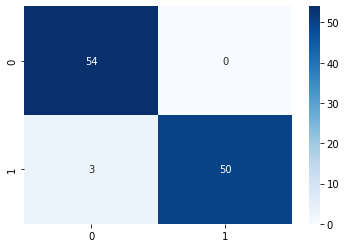

,KNN,NaiveBayes,Logistic_Regression,SVC,DecisionTrees,RF,GBDT,Stacked_classifer,voting_classifier
accuracy_score,0.971963,0.925234,0.990654,0.943925,0.953271,0.971963,0.971963,0.971963,0.971963
f1_score,0.970874,0.924528,0.990476,0.943396,0.952381,0.970874,0.970874,0.970874,0.970874
roc_auc_score,0.994060,0.987421,0.992313,0.982006,0.992662,0.994060,0.996157,0.994410,0.991265
log_loss,0.136667,0.230290,0.157186,0.436450,0.159192,0.104850,0.219619,0.093827,0.138406


In [70]:
voting_classif_pred = metrics(voting_classif,X_test,y_test,'voting_classifier')
result_dataset